# Quantum Cellular Automata

The following code is based on the article: https://medium.com/mit-6-s089-intro-to-quantum-computing/quantum-cellular-automata-implementing-an-elementary-cellular-automata-on-a-qc-736ea944042 <br>
The corresponding code from Richard Beattie can be found here: https://gist.github.com/r-bt/02681f41f6bbb594d1bf7ef08dc45739#file-quantum_cellular_automata-2-ipynb <br>

 I, Michele Fille, have updated the code to be compatible with the latest version of Qiskit (Qiskit 1.1.1).

In [1]:
# Import Python libraries for numerical computations and data visualisation
import numpy as np
import matplotlib.pyplot as plt

# Import necessary Qiskit libraries for creating and manipulating quantum circuits
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService

In [2]:
# Rule 30: binary patterns that result in the cell being 1 in the next timestep (True = 1, False = 0)
rule30 = [  
    [True, False, False],  # 100 -> True
    [False, True, True],   # 011 -> True
    [False, True, False],  # 010 -> True
    [False, False, True]   # 001 -> True
]

In [3]:
# Function to implement a triple Toffoli gate (CCCNOT)
def cccnot(circuit, c1, c2, c3, target):
    circuit.ccx(c1, c2, 0)     # First Toffoli gate: flips the auxiliary qubit (qubit 0) if both c1 and c2 are |1⟩
    circuit.ccx(c3, 0, target) # Second Toffoli gate: flips 'target' if c3 and the auxiliary qubit are |1⟩
    circuit.ccx(c1, c2, 0)     # Third Toffoli gate: resets the auxiliary qubit to its original state

In [4]:
# Function to apply a ruleset to a quantum circuit for a specific timestep and position within a collection of cells
def add_rule(circuit, n, timestep, position, rules):
    for rule in rules:  # Iterate over each rule in the rules list
        
        # Cell is on the left edge
        if position == 0:  
            if rule[0]:  # Skip rules requiring a left neighbour (rule[0] is True)
                continue  # Skip the current iteration and move to the next rule
            for i in range(1, 3):  # Handle the middle and right neighbours (i = 1, 2)
                if not rule[i]:  # Apply an X gate if the current neighbour condition is False (0)
                    circuit.x(n * timestep + position + i)  # Apply an X gate to the qubit identified by n * timestep + position + i
            circuit.ccx(  # Apply a Toffoli gate where the middle and right qubits are the control qubits, and the target qubit is the middle qubit in the next timestep
                n * timestep + position + 1,  # Middle neighbour
                n * timestep + position + 2,  # Right neighbour
                n * (timestep + 1) + position + 1  # Target qubit in the next timestep
            )
            for i in range(1, 3):  # Revert X gates so that the qubits are in their original state again
                if not rule[i]:
                    circuit.x(n * timestep + position + i)

        # Cell is on the right edge
        elif position == n - 1:  
            if rule[2]:  # Skip rules requiring a right neighbour (rule[2] is True)
                continue  # Skip the current iteration and move to the next rule
            for i in range(2):  # Handle the left and middle neighbours (i = 0, 1)
                if not rule[i]:  # Apply an X gate if the current neighbour condition is False (0)
                    circuit.x(n * timestep + position + i)  # Apply an X gate to the qubit identified by n * timestep + position + i
            circuit.ccx(  # Apply a Toffoli gate where the left and middle qubits are the control qubits, and the target qubit is the middle qubit in the next timestep
                n * timestep + position,  # Left neighbour
                n * timestep + position + 1,  # Middle neighbour
                n * (timestep + 1) + position + 1  # Target qubit in the next timestep
            )
            for i in range(2):  # Revert X gates so that the qubits are in their original state again
                if not rule[i]:
                    circuit.x(n * timestep + position + i)
        
        # Cell is neither on the left edge nor the right edge
        else:  
            for i in range(3):  # Handle the left, middle, and right neighbours (i = 0, 1, 2)
                if not rule[i]:  # Apply an X gate if the current neighbour condition is False (0)
                    circuit.x(n * timestep + position + i)  # Apply an X gate to the qubit identified by n * timestep + position + i
            cccnot(
                circuit,
                n * timestep + position,  # Left neighbour
                n * timestep + position + 1,  # Middle neighbour
                n * timestep + position + 2,  # Right neighbour
                n * (timestep + 1) + position + 1  # Target qubit in the next timestep
            )
            for i in range(3):  # Revert X gates so that the qubits are in their original state again
                if not rule[i]:
                    circuit.x(n * timestep + position + i)

In [5]:
# Function to apply rules to a quantum circuit for each timestep and position
def add_rules(circuit, n, m, rules):
    # Iterate over each timestep
    for i in range(m - 1):
        # Iterate over each position in the timestep
        for j in range(n):
            add_rule(circuit, n, i, j, rules)  # Apply add_rule function for each cell

    # Measure all qubits after applying the rules
    for i in range(0, n * m):
        circuit.measure(i + 1, i)  # Measure qubit i + 1 and store result in qubit i

In [ ]:
# Initialise the number of qubits per timestep (n) and the number of timesteps (m)
n = 7
m = 4

# Initialise a quantum circuit with n * m qubits + 1 auxiliary qubit and n * m classical bits
cirq1 = QuantumCircuit(n * m + 1, n * m)

# Configure the starting qubits here:
cirq1.x(4)  # Set the fourth qubit (index 4) to |1⟩ (middle qubit of the first timestep)

# Apply the ruleset to the quantum circuit
add_rules(cirq1, n, m, rule30)

# Draw the quantum circuit using the matplotlib drawer
cirq1.draw('mpl')

# Set up to run the program on a Simulator

In [7]:
# Set the backend to the AerSimulator backend and choose the simulation method 'statevector'
backend = AerSimulator(method='statevector')  

# Transpile the circuit to optimise it for the selected backend
new_circuit = transpile(cirq1, backend)

# Set the number of shots (repetitions of the circuit)
shots = 1024

# Execute the transpiled circuit on the backend and retrieve the job results
job = backend.run(new_circuit, shots=shots)
results = job.result()

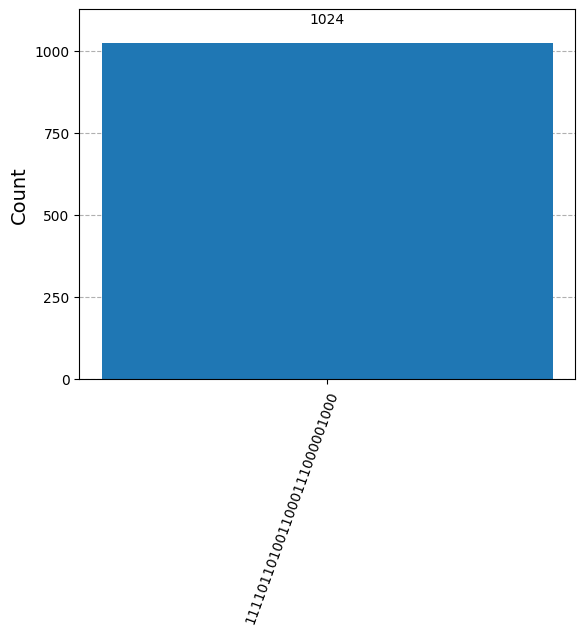

In [8]:
# Get the measurement counts from the results
counts = results.get_counts()

# Plot a histogram of the measurement results
plot_histogram(counts)

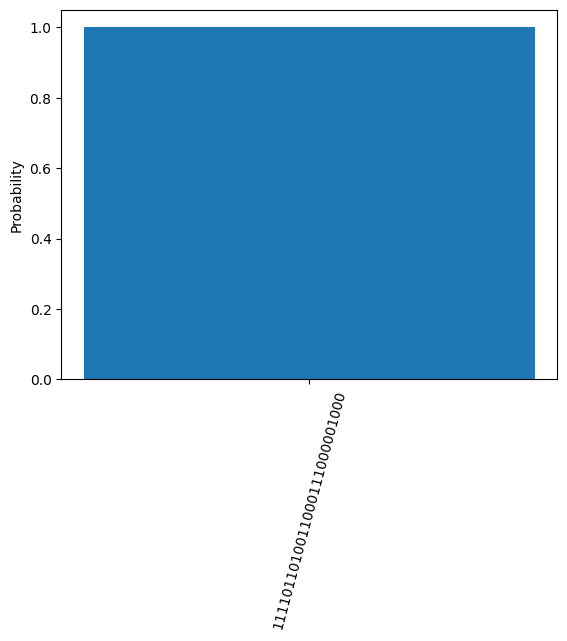

In [9]:
# Extract states and their probabilities
states = list(counts.keys())
probabilities = np.array(list(counts.values())) / shots

# Plot bar chart of probabilities
plt.bar(states, probabilities)
plt.ylabel('Probability')
plt.xticks(rotation=75)
plt.show()

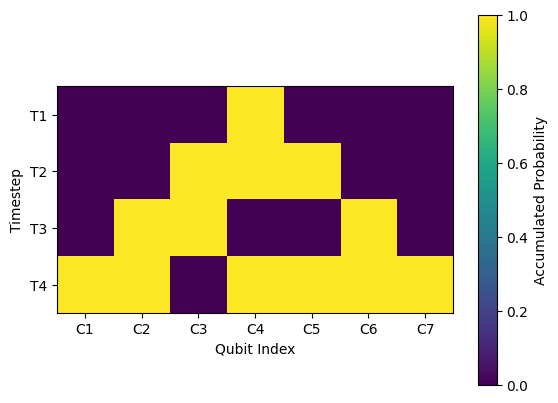

In [10]:
# Initialise a grid of zeros with dimensions (m, n)
grid = np.zeros((m, n))

# Iterate over each bitstring and its count in the counts dictionary
for bitstring, cnt in counts.items():
    # Calculate the probability of the bitstring occurring
    prob = cnt / shots
    
    # Iterate over each bit in the reversed bitstring
    for idx, c in enumerate(reversed(bitstring)):
        # If the bit is '1', update the corresponding cell in the grid with the probability
        if c == '1':
            # Calculate the row and column indices in the grid
            row = idx // n    # Integer division to get the row index
            col = idx % n     # Modulo operation to get the column index
            
            # Add the probability to the corresponding cell in the grid
            grid[row, col] += prob

# Plot the grid as an image using imshow
plt.imshow(grid, interpolation='nearest')
plt.colorbar(label='Accumulated Probability')
plt.xlabel('Qubit Index')
plt.ylabel('Timestep')
plt.xticks(range(n), labels=[f'C{i+1}' for i in range(n)])
plt.yticks(range(m), labels=[f'T{i+1}' for i in range(m)])
plt.show()

# Set up to run the program on one of the IBM quantum computers

In [ ]:
# Initialise the number of qubits per timestep (n) and the number of timesteps (m)
n = 7
m = 5 # can be increased as QC have more qubits

# Initialise a quantum circuit with n * m qubits + 1 auxiliary qubit and n * m classical bits
cirq2 = QuantumCircuit(n * m + 1, n * m)

# Configure the starting qubits here:
cirq2.x(4)  # Set the fourth qubit (index 4) to |1⟩ (middle qubit of the first timestep)

# Apply the ruleset to the quantum circuit
add_rules(cirq2, n, m, rule30)

# Draw the quantum circuit using the matplotlib drawer
cirq2.draw('mpl')

In [14]:
# Initialise your IBM account
service = QiskitRuntimeService(channel="ibm_quantum", token="your_token_here ") # please add your token here

# Retrieve list of available backends
backends = service.backends()

# Display information about available backends
for backend in backends:
    config = backend.configuration()
    print(f"{config.backend_name}: {config.n_qubits} qubits")

# Select an IBM Quantum Computer backend
backend_name = "ibm_kyoto"  # Other available QCs: ibm_osaka, ibm_kyoto, ibm_sherbrooke, ibm_brisbane
backend = service.backend(backend_name)

ibm_brisbane: 127 qubits
ibm_kyoto: 127 qubits
ibm_osaka: 127 qubits
ibm_sherbrooke: 127 qubits


your_token_here -> To get your API Token create a free account on the IBM Quantum Platform (here: https://quantum.ibm.com/), on the upper right side your API token can be copied and put in here.

In [15]:
# Transpile the circuit to optimise it for the selected backend
new_circuit2 = transpile(cirq2, backend)

# Set the number of shots (repetitions of the circuit) 
shots = 50 # number of shots decreased to decreas the number of occuring bitstrings

# Execute the transpiled circuit on the backend and retrieve the job results
job = backend.run(new_circuit2, shots=shots)
results = job.result()

C:\Users\miche\AppData\Local\Temp\ipykernel_13408\447850547.py:8: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job = backend.run(new_circuit2, shots=shots)


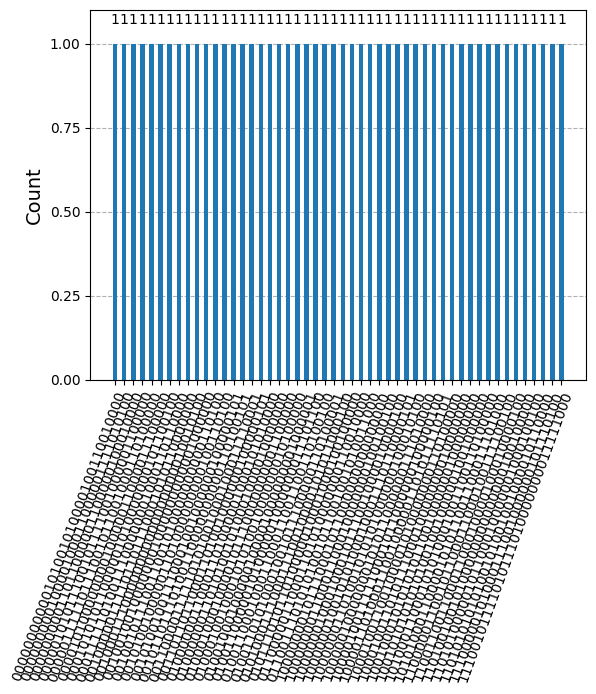

In [16]:
# Get the measurement counts from the results
counts = results.get_counts()

# Plot a histogram of the measurement results
plot_histogram(counts)

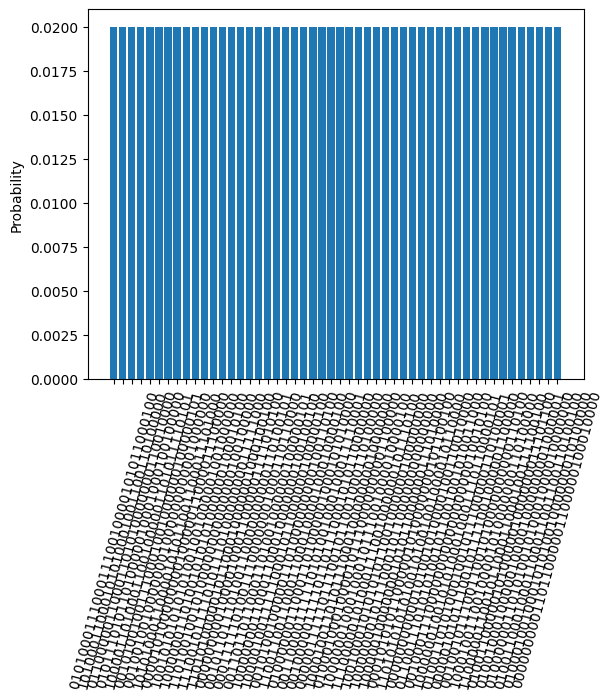

In [17]:
# Extract states and their probabilities
states = list(counts.keys())
probabilities = np.array(list(counts.values())) / shots

# Plot bar chart of probabilities
plt.bar(states, probabilities)
plt.ylabel('Probability')
plt.xticks(rotation=75)
plt.show()

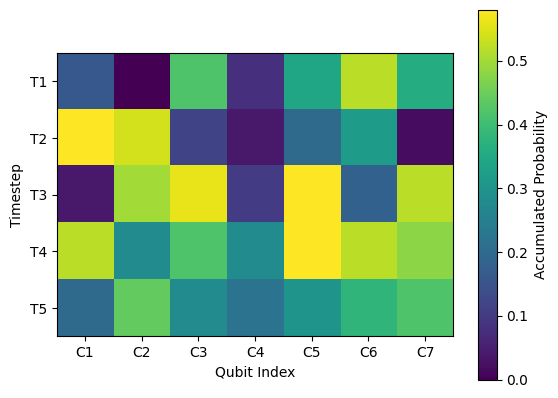

In [18]:
# Initialise a grid of zeros with dimensions (m, n)
grid = np.zeros((m, n))

# Iterate over each bitstring and its count in the counts dictionary
for bitstring, cnt in counts.items():
    # Calculate the probability of the bitstring occurring
    prob = cnt / shots
    
    # Iterate over each bit in the reversed bitstring
    for idx, c in enumerate(reversed(bitstring)):
        # If the bit is '1', update the corresponding cell in the grid with the probability
        if c == '1':
            # Calculate the row and column indices in the grid
            row = idx // n    # Integer division to get the row index
            col = idx % n     # Modulo operation to get the column index
            
            # Add the probability to the corresponding cell in the grid
            grid[row, col] += prob

# Plot the grid as an image using imshow
plt.imshow(grid, interpolation='nearest')
plt.colorbar(label='Accumulated Probability')
plt.xlabel('Qubit Index')
plt.ylabel('Timestep')
plt.xticks(range(n), labels=[f'C{i+1}' for i in range(n)])
plt.yticks(range(m), labels=[f'T{i+1}' for i in range(m)])
plt.show()

# other configurations of the starting qubits (using a simulator)
## applying a Hadamard gate to the fourth qubit (index 4) to |+⟩ (superposition)

In [ ]:
# Initialise the number of qubits per timestep (n) and the number of timesteps (m)
n = 7
m = 4

# Initialise a quantum circuit with n * m qubits + 1 auxiliary qubit and n * m classical bits
cirq3 = QuantumCircuit(n * m + 1, n * m)

# Other possible configurations for the starting qubits:
cirq3.h(4) # Set the fourth qubit (index 4) to |+⟩ (superposition) by applying a Hadamard gate

# Apply the ruleset to the quantum circuit
add_rules(cirq3, n, m, rule30)

# Draw the quantum circuit using the matplotlib drawer
cirq3.draw('mpl')

In [20]:
# Set the backend to the AerSimulator backend and choose the simulation method 'statevector'
backend = AerSimulator(method='statevector')  

# Transpile the circuit to optimize it for the selected backend
new_circuit3 = transpile(cirq3, backend)

# Set the number of shots (repetitions of the circuit)
shots = 1024

# Execute the transpiled circuit on the backend and retrieve the job results
job = backend.run(new_circuit3, shots=shots)
results = job.result()

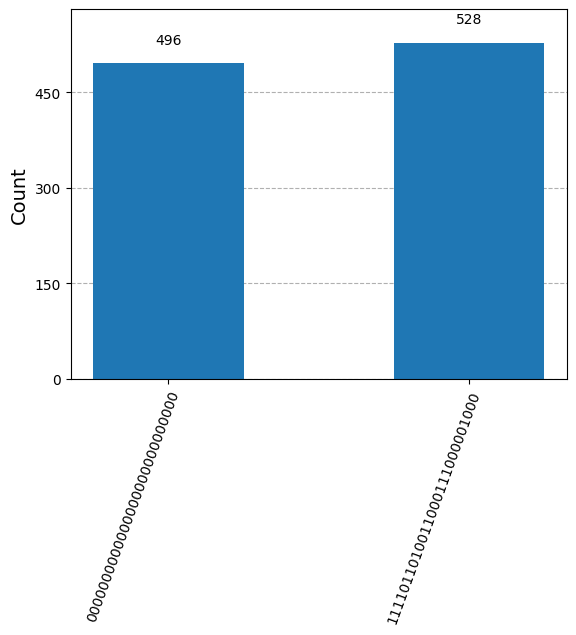

In [21]:
# Get the measurement counts from the results
counts = results.get_counts()

# Plot a histogram of the measurement results
plot_histogram(counts)

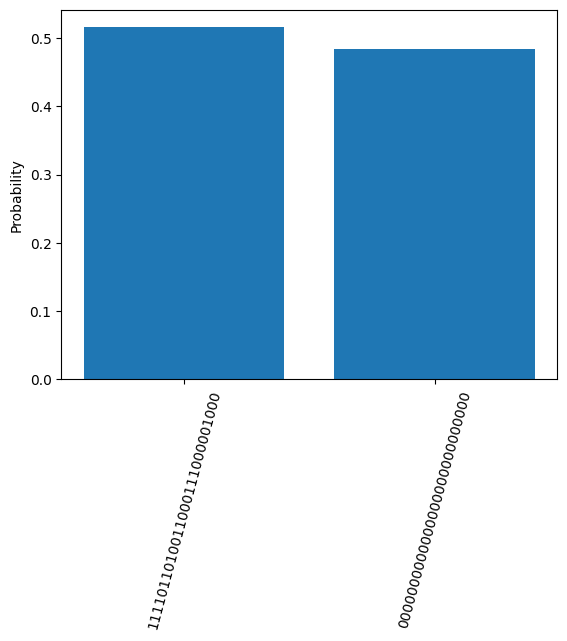

In [22]:
# Extract states and their probabilities
states = list(counts.keys())
probabilities = np.array(list(counts.values())) / shots

# Plot bar chart of probabilities
plt.bar(states, probabilities)
plt.ylabel('Probability')
plt.xticks(rotation=75)
plt.show()

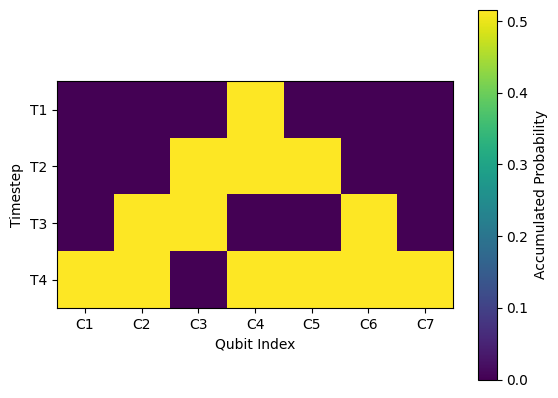

In [23]:
# Initialise a grid of zeros with dimensions (m, n)
grid = np.zeros((m, n))

# Iterate over each bitstring and its count in the counts dictionary
for bitstring, cnt in counts.items():
    # Calculate the probability of the bitstring occurring
    prob = cnt / shots
    
    # Iterate over each bit in the reversed bitstring
    for idx, c in enumerate(reversed(bitstring)):
        # If the bit is '1', update the corresponding cell in the grid with the probability
        if c == '1':
            # Calculate the row and column indices in the grid
            row = idx // n    # Integer division to get the row index
            col = idx % n     # Modulo operation to get the column index
            
            # Add the probability to the corresponding cell in the grid
            grid[row, col] += prob

# Plot the grid as an image using imshow
plt.imshow(grid, interpolation='nearest')
plt.colorbar(label='Accumulated Probability')
plt.xlabel('Qubit Index')
plt.ylabel('Timestep')
plt.xticks(range(n), labels=[f'C{i+1}' for i in range(n)])
plt.yticks(range(m), labels=[f'T{i+1}' for i in range(m)])
plt.show()

## applying a X gate to qubit 4 and a Hadamard gate to qubit 5 (superposition)

In [ ]:
# Initialise the number of qubits per timestep (n) and the number of timesteps (m)
n = 7
m = 4

# Initialise a quantum circuit with n * m qubits + 1 auxiliary qubit and n * m classical bits
cirq4 = QuantumCircuit(n * m + 1, n * m)

# Other possible configurations for the starting qubits:
cirq4.x(4) # Set the fourth qubit (index 4) to |1⟩ (middle qubit of the first timestep)
cirq4.h(5) # Set the fifth qubit (index 5) to |+⟩ (superposition) by applying a Hadamard gate

# Apply the ruleset to the quantum circuit
add_rules(cirq4, n, m, rule30)

# Draw the quantum circuit using the matplotlib drawer
cirq4.draw('mpl')


In [25]:
# Set the backend to the AerSimulator backend and choose the simulation method 'statevector'
backend = AerSimulator(method='statevector')  

# Transpile the circuit to optimize it for the selected backend
new_circuit4 = transpile(cirq4, backend)

# Set the number of shots (repetitions of the circuit)
shots = 1024

# Execute the transpiled circuit on the backend and retrieve the job results
job = backend.run(new_circuit4, shots=shots)
results = job.result()

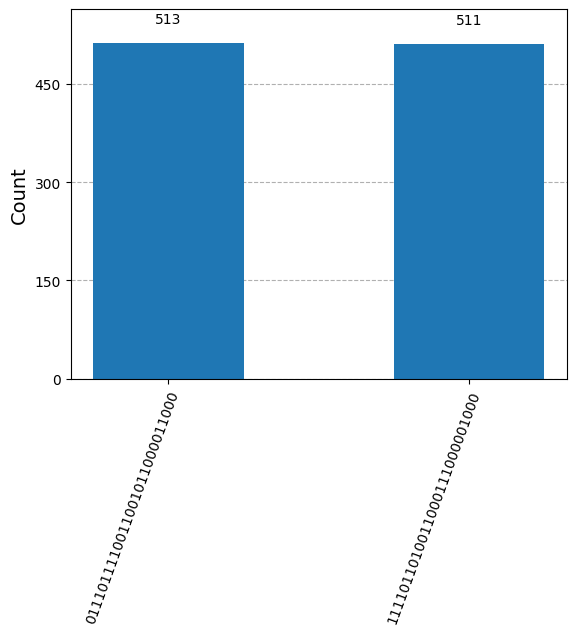

In [26]:
# Get the measurement counts from the results
counts = results.get_counts()

# Plot a histogram of the measurement results
plot_histogram(counts)

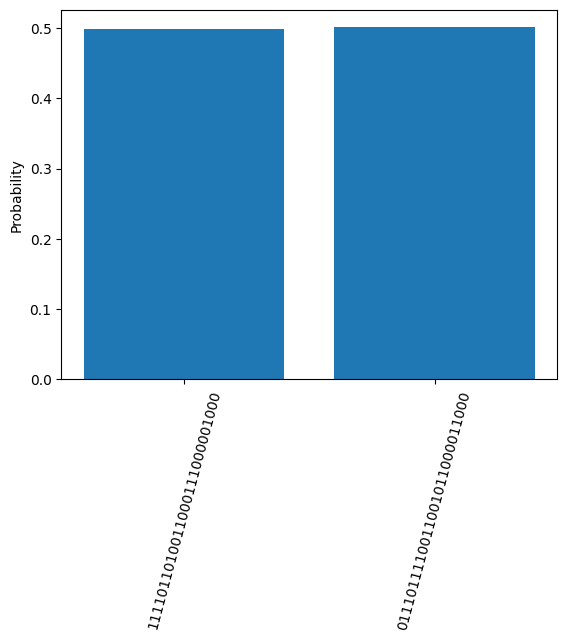

In [27]:
# Extract states and their probabilities
states = list(counts.keys())
probabilities = np.array(list(counts.values())) / shots

# Plot bar chart of probabilities
plt.bar(states, probabilities)
plt.ylabel('Probability')
plt.xticks(rotation=75)
plt.show()

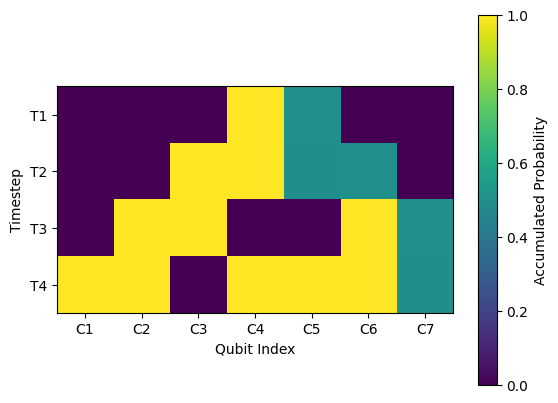

In [28]:
# Initialise a grid of zeros with dimensions (m, n)
grid = np.zeros((m, n))

# Iterate over each bitstring and its count in the counts dictionary
for bitstring, cnt in counts.items():
    # Calculate the probability of the bitstring occurring
    prob = cnt / shots
    
    # Iterate over each bit in the reversed bitstring
    for idx, c in enumerate(reversed(bitstring)):
        # If the bit is '1', update the corresponding cell in the grid with the probability
        if c == '1':
            # Calculate the row and column indices in the grid
            row = idx // n    # Integer division to get the row index
            col = idx % n     # Modulo operation to get the column index
            
            # Add the probability to the corresponding cell in the grid
            grid[row, col] += prob

# Plot the grid as an image using imshow
plt.imshow(grid, interpolation='nearest')
plt.colorbar(label='Accumulated Probability')
plt.xlabel('Qubit Index')
plt.ylabel('Timestep')
plt.xticks(range(n), labels=[f'C{i+1}' for i in range(n)])
plt.yticks(range(m), labels=[f'T{i+1}' for i in range(m)])
plt.show()

## applying a X gate to qubit 4 and a Hadamard gate to the all qubit (index 5) to |+⟩ (superposition) except the fourth cell

In [29]:
# Initialise rule 90 and 122

rule90 = [  
    [True, True, False], 
    [True, False, False], 
    [False, True, True], 
    [False, False, True] 
]

rule122 = [  
    [True, True, False], 
    [True, False, True],  
    [True, False, False],
    [False, True, True],
    [False, False, True] 
]

In [102]:
# Initialise the number of qubits per timestep (n) and the number of timesteps (m)
n = 7
m = 4

# Initialise a quantum circuit with n * m qubits + 1 auxiliary qubit and n * m classical bits
cirq30 = QuantumCircuit(n * m + 1, n * m)

# Other possible configurations for the starting qubits:
cirq30.x(4)  # Set the fourth qubit (index 4) to |1⟩ (middle qubit of the first timestep)

# Set all cells to a superposition except the fourth cell and auxiliary qubit
for i in range(n): 
     if i != 3: 
         cirq30.h(i + 1) 

# Create copies of the quantum circuit cirq30 for rule 90 and 122
cirq90 = cirq30.copy()  
cirq122 = cirq30.copy()  

# Apply the ruleset to the quantum circuit
add_rules(cirq30, n, m, rule30)
add_rules(cirq90, n, m, rule90)
add_rules(cirq122, n, m, rule122)

# Draw the quantum circuit using the matplotlib drawer
cirq30.draw('mpl')
cirq90.draw('mpl')
cirq122.draw('mpl')

In [103]:
# Set the backend to the AerSimulator backend and choose the simulation method 'statevector'
backend = AerSimulator(method='statevector') 

# Transpile the circuit to optimize it for the selected backend
new_circuit30 = transpile(cirq30, backend)
new_circuit90 = transpile(cirq90, backend)
new_circuit122 = transpile(cirq122, backend)

# Set the number of shots (repetitions of the circuit)
shots = 1024

# Execute the transpiled circuit on the backend and retrieve the job results
job30 = backend.run(new_circuit30, shots=shots)
results30 = job30.result()

job90 = backend.run(new_circuit90, shots=shots)
results90 = job90.result()

job122 = backend.run(new_circuit122, shots=shots)
results122 = job122.result()

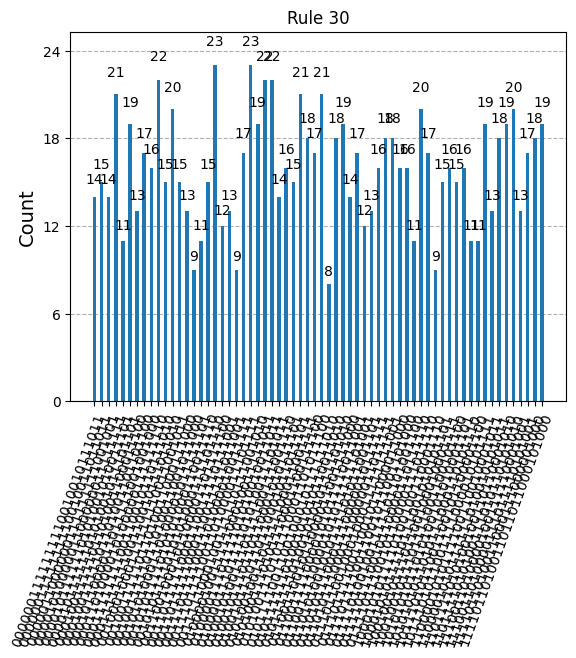

In [104]:
# Get the measurement counts from the results
counts30 = results30.get_counts()

# Plot a histogram of the measurement results
plot_histogram(counts30, title='Rule 30')

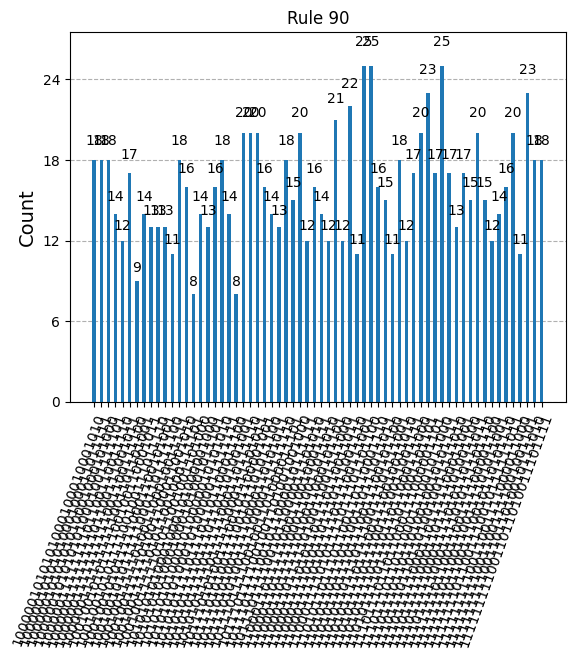

In [105]:
# Get the measurement counts from the results
counts90 = results90.get_counts()

# Plot a histogram of the measurement results
plot_histogram(counts90, title='Rule 90')

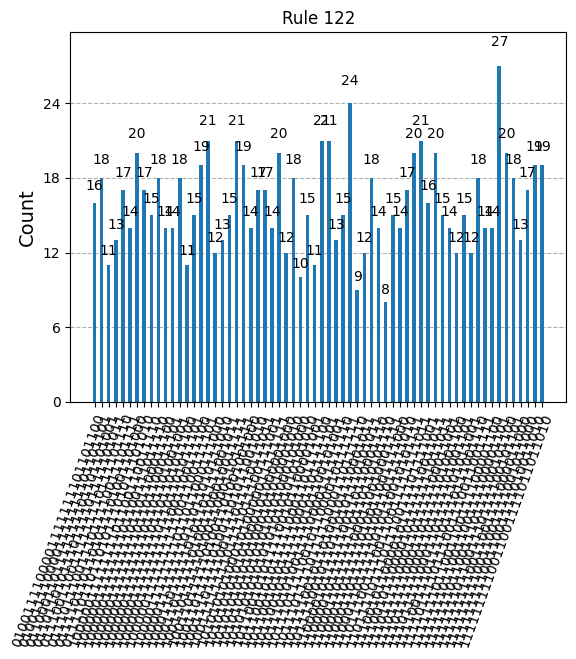

In [106]:
# Get the measurement counts from the results
counts122 = results122.get_counts()

# Plot a histogram of the measurement results
plot_histogram(counts122, title='Rule 122')

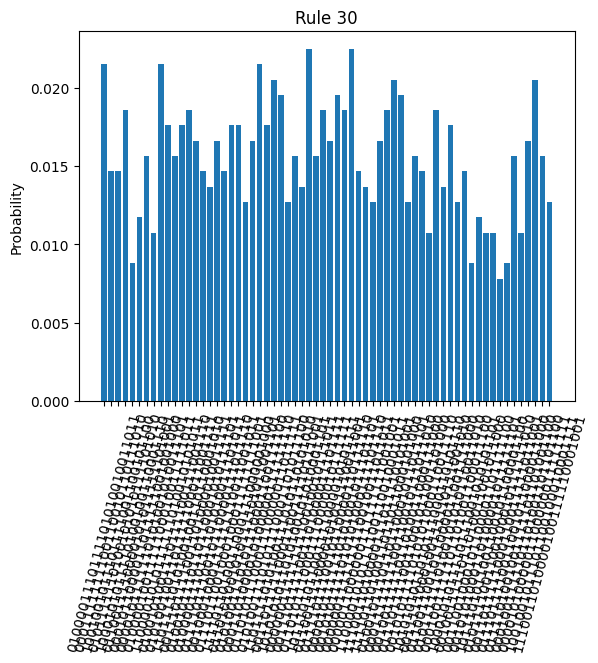

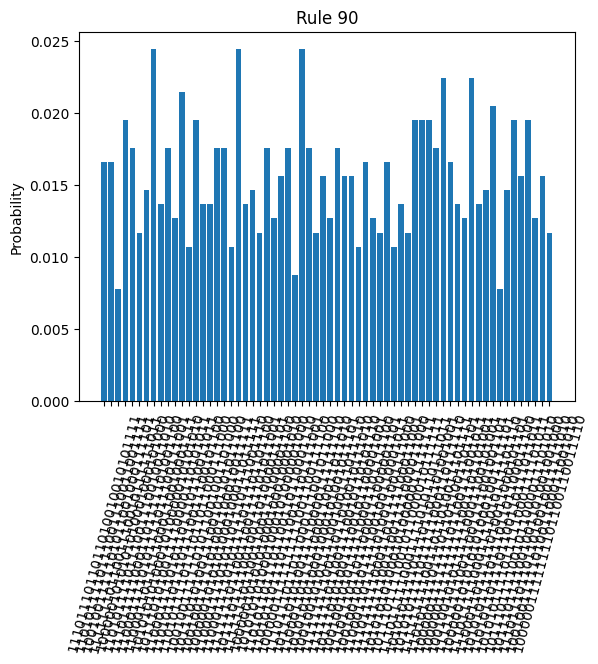

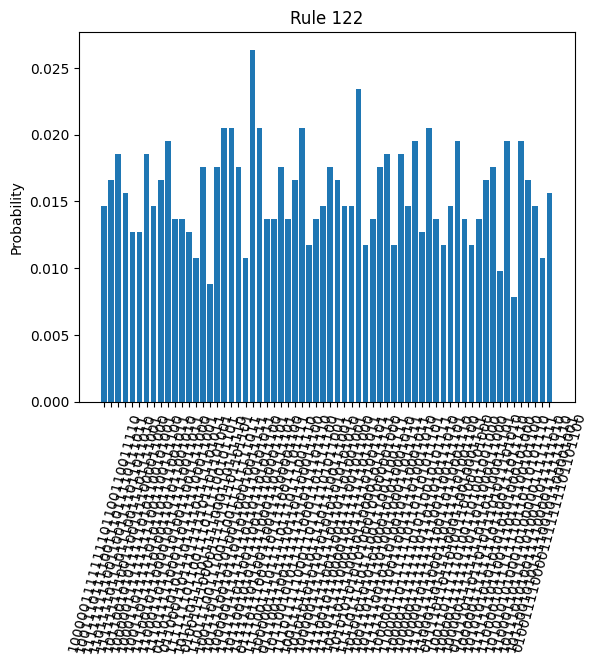

In [107]:
# Extract states and their probabilities
states30 = list(counts30.keys())
probabilities30 = np.array(list(counts30.values())) / shots

states90 = list(counts90.keys())
probabilities90 = np.array(list(counts90.values())) / shots

states122 = list(counts122.keys())
probabilities122 = np.array(list(counts122.values())) / shots

# Plot bar chart of probabilities
plt.bar(states30, probabilities30)
plt.title('Rule 30')
plt.ylabel('Probability')
plt.xticks(rotation=75)
plt.show()

plt.bar(states90, probabilities90)
plt.title('Rule 90')
plt.ylabel('Probability')
plt.xticks(rotation=75)
plt.show()

plt.bar(states122, probabilities122)
plt.title('Rule 122')
plt.ylabel('Probability')
plt.xticks(rotation=75)
plt.show()

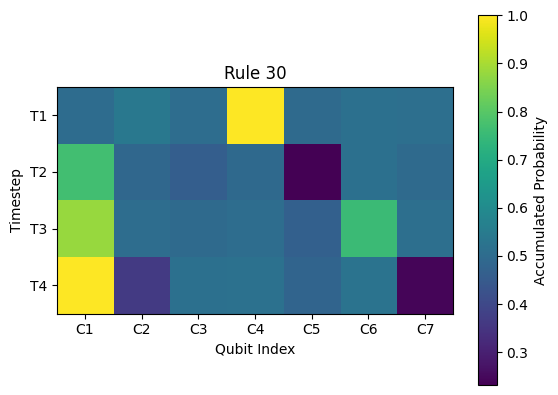

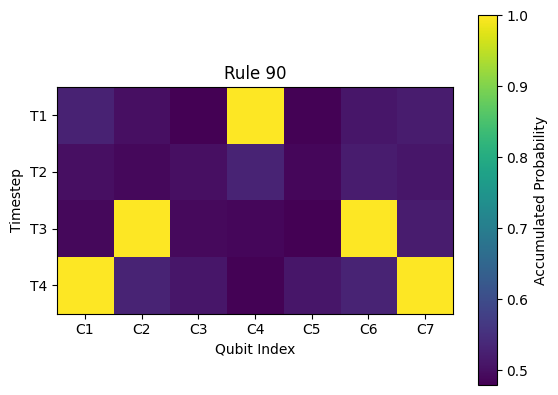

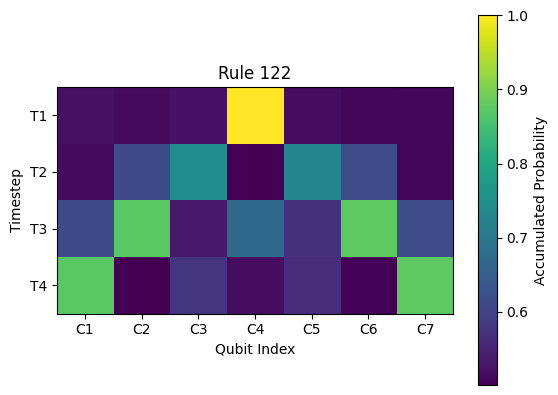

In [108]:
# Initialise a grid of zeros with dimensions (m, n)
grid30 = np.zeros((m, n))
grid90 = np.zeros((m, n))
grid122 = np.zeros((m, n))

# Iterate over each bitstring and its count in the counts dictionary
for bitstring, cnt in counts30.items():
    # Calculate the probability of the bitstring occurring
    prob = cnt / shots
    
    # Iterate over each bit in the reversed bitstring
    for idx, c in enumerate(reversed(bitstring)):
        # If the bit is '1', update the corresponding cell in the grid with the probability
        if c == '1':
            # Calculate the row and column indices in the grid
            row = idx // n    # Integer division to get the row index
            col = idx % n     # Modulo operation to get the column index
            
            # Add the probability to the corresponding cell in the grid
            grid30[row, col] += prob

# Plot the grid as an image using imshow
plt.imshow(grid30, interpolation='nearest')
plt.colorbar(label='Accumulated Probability')
plt.title('Rule 30')
plt.xlabel('Qubit Index')
plt.ylabel('Timestep')
plt.xticks(range(n), labels=[f'C{i+1}' for i in range(n)])
plt.yticks(range(m), labels=[f'T{i+1}' for i in range(m)])
plt.show()

# Iterate over each bitstring and its count in the counts dictionary
for bitstring, cnt in counts90.items():
    # Calculate the probability of the bitstring occurring
    prob = cnt / shots
    
    # Iterate over each bit in the reversed bitstring
    for idx, c in enumerate(reversed(bitstring)):
        # If the bit is '1', update the corresponding cell in the grid with the probability
        if c == '1':
            # Calculate the row and column indices in the grid
            row = idx // n    # Integer division to get the row index
            col = idx % n     # Modulo operation to get the column index
            
            # Add the probability to the corresponding cell in the grid
            grid90[row, col] += prob


# Plot the grid as an image using imshow
plt.imshow(grid90, interpolation='nearest')
plt.colorbar(label='Accumulated Probability')
plt.title('Rule 90')
plt.xlabel('Qubit Index')
plt.ylabel('Timestep')
plt.xticks(range(n), labels=[f'C{i+1}' for i in range(n)])
plt.yticks(range(m), labels=[f'T{i+1}' for i in range(m)])
plt.show()

# Iterate over each bitstring and its count in the counts dictionary
for bitstring, cnt in counts122.items():
    # Calculate the probability of the bitstring occurring
    prob = cnt / shots
    
    # Iterate over each bit in the reversed bitstring
    for idx, c in enumerate(reversed(bitstring)):
        # If the bit is '1', update the corresponding cell in the grid with the probability
        if c == '1':
            # Calculate the row and column indices in the grid
            row = idx // n    # Integer division to get the row index
            col = idx % n     # Modulo operation to get the column index
            
            # Add the probability to the corresponding cell in the grid
            grid122[row, col] += prob

# Plot the grid as an image using imshow
plt.imshow(grid122, interpolation='nearest')
plt.colorbar(label='Accumulated Probability')
plt.title('Rule 122')
plt.xlabel('Qubit Index')
plt.ylabel('Timestep')
plt.xticks(range(n), labels=[f'C{i+1}' for i in range(n)])
plt.yticks(range(m), labels=[f'T{i+1}' for i in range(m)])
plt.show()